In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from matplotlib import pyplot as plt

In [3]:
spark = SparkSession.builder\
        .appName("Demp01")\
        .config("spark.sql.shuffle.partitions","2")\
        .getOrCreate()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


In [4]:
jdbcurl = "jdbc:mysql://localhost:3306/dbda_db"
jdbcdriver = "com.mysql.cj.jdbc.Driver"
tb1 = "emp"
tb2 = "dept"

user = "root"
passw = "manager"

In [5]:
df1 = spark.read\
     .option("driver",jdbcdriver)\
     .option("user",user)\
     .option("password",passw)\
     .jdbc(url=jdbcurl,table=tb1)

df1.printSchema()

root
 |-- empno: integer (nullable = true)
 |-- ename: string (nullable = true)
 |-- job: string (nullable = true)
 |-- mgr: integer (nullable = true)
 |-- hire: date (nullable = true)
 |-- sal: decimal(8,2) (nullable = true)
 |-- comm: decimal(8,2) (nullable = true)
 |-- deptno: integer (nullable = true)



In [6]:
df1.show()

SLF4J: Failed to load class "org.slf4j.impl.StaticMDCBinder".
SLF4J: Defaulting to no-operation MDCAdapter implementation.
SLF4J: See http://www.slf4j.org/codes.html#no_static_mdc_binder for further details.


+-----+------+---------+----+----------+-------+-------+------+
|empno| ename|      job| mgr|      hire|    sal|   comm|deptno|
+-----+------+---------+----+----------+-------+-------+------+
| 7369| SMITH|    CLERK|7902|1980-12-17| 888.00|   NULL|    20|
| 7499| ALLEN| SALESMAN|7698|1981-02-20|1600.00| 300.00|    30|
| 7521|  WARD| SALESMAN|7698|1981-02-22|1250.00| 500.00|    30|
| 7566| JONES|  MANAGER|7839|1981-04-02|2975.00|   NULL|    20|
| 7654|MARTIN| SALESMAN|7698|1981-09-28|1250.00|1400.00|    30|
| 7698| BLAKE|  MANAGER|7839|1981-05-01|2850.00|   NULL|    30|
| 7782| CLARK|  MANAGER|7839|1981-06-09|2450.00|   NULL|    10|
| 7788| SCOTT|  ANALYST|7566|1982-12-09|3000.00|   NULL|    20|
| 7839|  KING|PRESIDENT|NULL|1981-11-17|5000.00|   NULL|    10|
| 7844|TURNER| SALESMAN|7698|1981-09-08|1500.00|   0.00|    30|
| 7876| ADAMS|    CLERK|7788|1983-01-12|1100.00|   NULL|    20|
| 7900| JAMES|    CLERK|7698|1981-12-03| 950.00|   NULL|    30|
| 7902|  FORD|  ANALYST|7566|1981-12-03|

In [7]:
df2 = spark.read\
      .option("driver",jdbcdriver)\
      .option("user",user)\
      .option("password",passw)\
      .jdbc(url=jdbcurl,table=tb2)

df2.show()

+------+----------+--------+
|deptno|     dname|     loc|
+------+----------+--------+
|    10|ACCOUNTING|NEW YORK|
|    20|  RESEARCH|  DALLAS|
|    30|     SALES| CHICAGO|
|    40|OPERATIONS|  BOSTON|
+------+----------+--------+



In [10]:
joined = df1.alias("e1").join(df2.alias("d1"),col("e1.deptno")==col("d1.deptno"))

In [12]:
#Deptwise total salary

plt1 = joined.groupBy("dname").agg(sum("sal").alias("totalsalary"))

plt1.show()

+----------+-----------+
|     dname|totalsalary|
+----------+-----------+
|ACCOUNTING|    8750.00|
|  RESEARCH|   10963.00|
|     SALES|    9400.00|
+----------+-----------+



In [18]:
plt1_df = plt1.toPandas()

<BarContainer object of 3 artists>

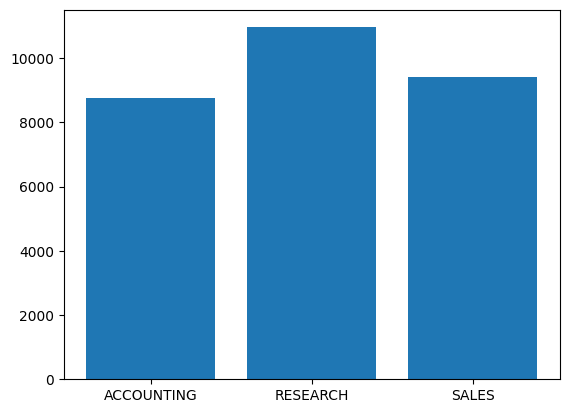

In [19]:
plt.bar(plt1_df['dname'],plt1_df['totalsalary'])

In [20]:
df2 = joined.groupBy("dname","job").agg(count("empno").alias("empcount"))

df2.show()

+----------+---------+--------+
|     dname|      job|empcount|
+----------+---------+--------+
|ACCOUNTING|  MANAGER|       1|
|ACCOUNTING|PRESIDENT|       1|
|  RESEARCH|    CLERK|       2|
|     SALES|  MANAGER|       1|
|     SALES|    CLERK|       1|
|ACCOUNTING|    CLERK|       1|
|     SALES| SALESMAN|       4|
|  RESEARCH|  MANAGER|       1|
|  RESEARCH|  ANALYST|       2|
+----------+---------+--------+



In [21]:
pd_df2 =df2.toPandas()


In [22]:
pd_df2

,dname,job,empcount
0,ACCOUNTING,PRESIDENT,1
1,ACCOUNTING,MANAGER,1
2,RESEARCH,CLERK,2
3,SALES,CLERK,1
4,SALES,MANAGER,1
5,ACCOUNTING,CLERK,1
6,RESEARCH,ANALYST,2
7,RESEARCH,MANAGER,1
8,SALES,SALESMAN,4


TypeError: plot() got an unexpected keyword argument 'x'

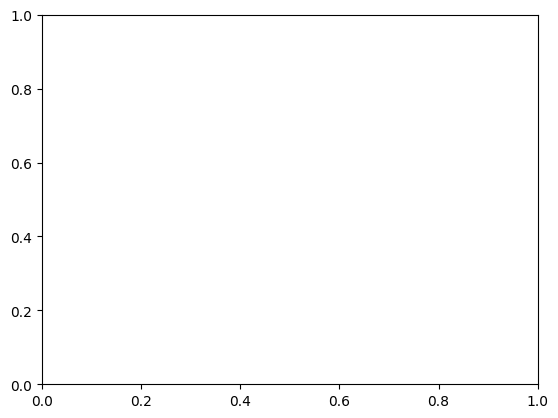

In [25]:
plt.plot(x=pd_df2["dname"],y=[pd_df2["job"],pd_df2["empcount"]],kind="bar")

In [27]:
# Salary proportion per emp (out of total sal)
dbtable = "totalsal_prop"

df3 = joined.select("ename","sal","d1.deptno")

df3.show()

+------+-------+------+
| ename|    sal|deptno|
+------+-------+------+
|MILLER|1300.00|    10|
|  KING|5000.00|    10|
| CLARK|2450.00|    10|
|  FORD|3000.00|    20|
| ADAMS|1100.00|    20|
| SCOTT|3000.00|    20|
| JONES|2975.00|    20|
| SMITH| 888.00|    20|
| JAMES| 950.00|    30|
|TURNER|1500.00|    30|
| BLAKE|2850.00|    30|
|MARTIN|1250.00|    30|
|  WARD|1250.00|    30|
| ALLEN|1600.00|    30|
+------+-------+------+



In [28]:
df3.createOrReplaceTempView("sal_prp")

In [31]:
spark.sql("SELECT ename ,sal,deptno FROM sal_prp WHERE deptno <=> 20").show()

+-----+-------+------+
|ename|    sal|deptno|
+-----+-------+------+
| FORD|3000.00|    20|
|ADAMS|1100.00|    20|
|SCOTT|3000.00|    20|
|JONES|2975.00|    20|
|SMITH| 888.00|    20|
+-----+-------+------+

